In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
N = 100 # number of points per class
D = 2 # dimensionality, we use 2D data for easy visulization
K = 3 # number of classes
X = np.zeros((N * K, D), dtype = float) # data matrix (each row = single example, can view as xy coordinates)
y = np.zeros(N * K, dtype = int) # class labels 

for i in range(K):
    r = np.random.normal(i + 0.5, 0.3, (N, 1)) # radius
    t = np.linspace(0, np.pi * 2, N).reshape(N, 1)  # theta
    X[i * N:(i + 1) * N] = np.append(r * np.sin(t), r * np.cos(t), axis = 1)
    y[i * N:(i + 1) * N] = i

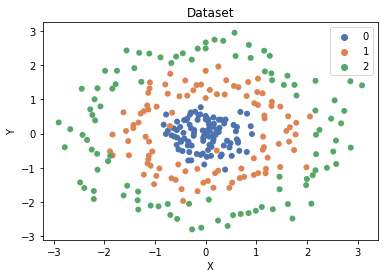

In [3]:
sns.scatterplot(x = X[:, 0], y = X[:, 1], 
                hue = y, palette = sns.color_palette('deep', K), edgecolor = "none")
plt.title('Dataset')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [4]:
def gini_impurity(y):
    # calculate gini_impurity given labels/classes of each example
    m = y.shape[0]
    cnts = dict(zip(*np.unique(y, return_counts = True)))
    impurity = 1 - sum((cnt/m)**2 for cnt in cnts.values())
    return impurity

In [5]:
def test_split(index, value, X, y):
    # split a group of examples based on given index (feature) and value
    mask = X[:, index] < value 
    left = {'X': X[mask, :], 'y': y[mask]}
    right = {'X': X[~mask, :], 'y': y[~mask]}
    return left, right

In [6]:
def info_gain(l_y, r_y, cur_gini):
    # calculate the information gain for a certain split
    m, n = l_y.shape[0], r_y.shape[0]
    p = m / (m + n)
    return cur_gini - p * gini_impurity(l_y) - (1 - p) * gini_impurity(r_y)

In [7]:
def get_split(X, y):
    # loop through features and values to find best combination with the most information gain
    best_gain, best_index, best_value = 0, None, None
    
    cur_gini = gini_impurity(y)
    n_features = X.shape[1]  

    for index in range(n_features):  

        values = np.unique(X[:, index], return_counts = False)  

        for value in values:  

            left, right = test_split(index, value, X, y)

            if left['y'].shape[0] == 0 or right['y'].shape[0] == 0:
                continue

            gain = info_gain(left['y'], right['y'], cur_gini)

            if gain > best_gain:
                best_gain, best_index, best_value = gain, index, value
    best_split = {'gain': best_gain, 'index': best_index, 'value': best_value}
    return best_split

In [8]:
class Leaf:
    # define a leaf node
    def __init__(self, y):
        self.counts = dict(zip(*np.unique(y, return_counts = True)))
        self.prediction = max(self.counts.keys(), key = lambda x: self.counts[x])

In [9]:
class Decision_Node:
    # define a decision node
    def __init__(self, index, value, left, right):
        self.index, self.value = index, value
        self.left, self.right = left, right

In [10]:
def decision_tree(X, y, max_dep = 5, min_size = 10):
    # train the decision tree model with a dataset
    correct_prediction = 0
    
    def build_tree(X, y, dep, max_dep = max_dep, min_size = min_size):
        # recursively build the tree
        split = get_split(X, y)

        if split['gain'] == 0 or dep >= max_dep or y.shape[0] <= min_size:
            nonlocal correct_prediction
            leaf = Leaf(y)
            correct_prediction += leaf.counts[leaf.prediction]
            return leaf

        left, right = test_split(split['index'], split['value'], X, y)

        left_node = build_tree(left['X'], left['y'], dep + 1)
        right_node = build_tree(right['X'], right['y'], dep + 1)

        return Decision_Node(split['index'], split['value'], left_node, right_node)
    
    root = build_tree(X, y, 0)
    
    return correct_prediction/y.shape[0], root

In [11]:
overfit_accuracy, overfit_model = decision_tree(X, y, float('inf'), 1)
accuracy, model = decision_tree(X, y, 6)

In [12]:
print('The accuracy of a model with unlimited split is {:.2f} %'.format(overfit_accuracy*100))
print('With limited split, the accuracy becomes {:.2f} %'.format(accuracy*100))

The accuracy of a model with unlimited split is 100.00 %
With limited split, the accuracy becomes 94.67 %


In [13]:
def print_tree(node, spacing = ""):
    # print the tree
    if isinstance(node, Leaf):
        print (spacing + "Predict", node.prediction)
        return

    print (spacing + 'split at index:' + str(node.index) + 
           ' with value:' + str(round(node.value, 2)))

    print (spacing + '--> True:')
    print_tree(node.left, spacing + "  ")

    print (spacing + '--> False:')
    print_tree(node.right, spacing + "  ")

In [14]:
print_tree(model)

split at index:1 with value:-1.63
--> True:
  split at index:1 with value:-1.97
  --> True:
    Predict 2
  --> False:
    Predict 2
--> False:
  split at index:1 with value:0.65
  --> True:
    split at index:1 with value:-0.68
    --> True:
      split at index:0 with value:-1.22
      --> True:
        Predict 2
      --> False:
        split at index:0 with value:1.46
        --> True:
          split at index:1 with value:-0.91
          --> True:
            Predict 1
          --> False:
            Predict 1
        --> False:
          Predict 2
    --> False:
      split at index:0 with value:-0.83
      --> True:
        split at index:0 with value:-1.84
        --> True:
          split at index:0 with value:-1.89
          --> True:
            Predict 2
          --> False:
            Predict 1
        --> False:
          Predict 1
      --> False:
        split at index:0 with value:1.13
        --> True:
          split at index:0 with value:-0.63
          --> True:


In [15]:
def predict(x, node):
    if isinstance(node, Leaf):
        return node.prediction
    
    if x[node.index] < node.value:
        return predict(x, node.left)
    else:
        return predict(x, node.right)

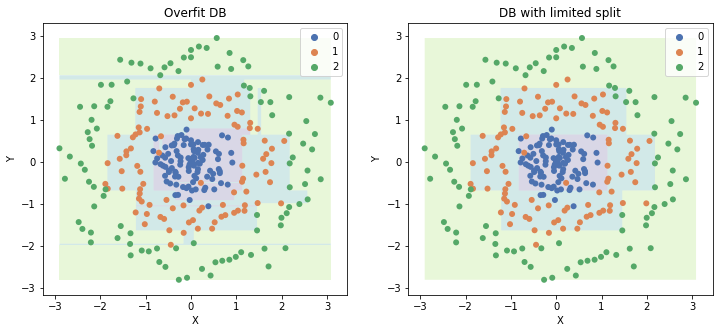

In [16]:
u = np.linspace(min(X[:, 0]),max(X[:, 0]), 400)  
v = np.linspace(min(X[:, 1]),max(X[:, 1]), 400)

models = [overfit_model, model]
titles = ['Overfit DB', 'DB with limited split']

fig, axs = plt.subplots(ncols = 2, figsize = (12, 5))
for k, ax in enumerate(axs):
    z = np.zeros((len(u),len(v)))
    for i in range(len(u)):
            for j in range(len(v)):
                z[i,j] = predict([u[i], v[j]], models[k])   

    z = np.transpose(z)

    ax.contourf(u,v,z, alpha = 0.2, levels = K - 1, antialiased = True)   

    sns.scatterplot(x = X[:, 0], y = X[:, 1], hue = y, 
                    palette = sns.color_palette('deep', K), edgecolor = "none", ax = ax)
    ax.set_title(titles[k])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
plt.show()